In [1]:
import os
import tensorflow as tf
import pandas as pd
from  tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
tf.enable_eager_execution()

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128
IMG_SIZE = (224, 224)
IMG_SHAPE = (224, 224, 3)

In [3]:
PATH = '/media/nvidia/Elements/panoptic-toolbox/171204_pose1/rotationnet4/'
train_directory = os.path.join(PATH, 'train/images/')
val_directory = os.path.join(PATH, 'val/images/')

In [5]:
train_df = pd.read_csv(train_directory + 'train.csv')
val_df = pd.read_csv(val_directory + 'val.csv')

In [6]:
train_file_paths = train_df['file_name'].values
train_labels = train_df['label'].values
val_file_paths = val_df['file_name'].values
val_labels = val_df['label'].values

In [7]:
ds_train = tf.data.Dataset.from_tensor_slices((train_file_paths, train_labels))
ds_val = tf.data.Dataset.from_tensor_slices((val_file_paths, val_labels))
ds_train = ds_train.shuffle(124380)
ds_val = ds_val.shuffle(40764)

In [8]:
def read_image_for_training(image_file, label):
    image = tf.io.read_file(train_directory+image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    return image, label

def read_image_for_validation(image_file, label):
    image = tf.io.read_file(val_directory+image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    return image, label

In [9]:
def normalize_image(image, label):
    #normalize image value to [0,1] range
    return tf.cast(image, tf.float32) / 255.0, label

In [10]:
def augment(image,label):
    image = tf.image.resize(image, IMG_SIZE)
    angle = tf.random.uniform(shape=[1],minval=-179.99999, maxval=180, dtype=tf.float64)
    image = tf.contrib.image.rotate(image, tf.cast(angle, tf.float32) * 0.01745329251, interpolation='BILINEAR')
    return image, tf.cast(angle+label, tf.float32)

In [11]:
ds_train = ds_train.map(read_image_for_training, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.map(normalize_image, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.map(augment, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(AUTOTUNE)

ds_val = ds_val.map(read_image_for_validation, num_parallel_calls=AUTOTUNE)
ds_val = ds_val.map(normalize_image, num_parallel_calls=AUTOTUNE)
ds_val = ds_val.map(augment, num_parallel_calls=AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE)
ds_val = ds_val.prefetch(AUTOTUNE)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



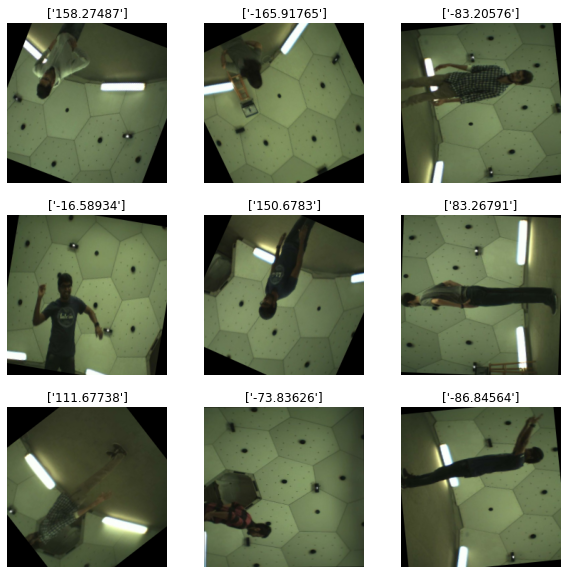

In [51]:
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("float32"))
        plt.title(labels[i].numpy().astype("str"))
        plt.axis("off")

plt.savefig('preprocessed data')

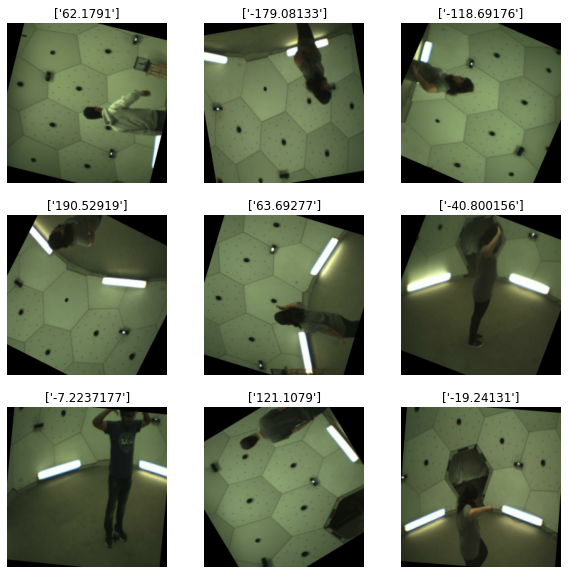

In [50]:
plt.figure(figsize=(10, 10))
for images, labels in ds_val.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("float32"))
        plt.title(labels[i].numpy().astype("str"))
        plt.axis("off")
        
plt.savefig('preprocessed data')


In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                                 include_top = True,
                                                 weights = 'imagenet')

In [15]:
base_model.trainable = True
fine_tune_at = 155
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [16]:
model = tf.keras.Sequential([
    base_model,
    keras.layers.Dense(32),
    keras.layers.Activation('relu'),
    keras.layers.Dense(1)])

In [17]:
model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.RMSprop(0.0001),
                metrics=['mean_absolute_error', 'mean_squared_error'])

In [18]:
EarlyStoppage = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)

In [19]:
history = model.fit(ds_train, validation_data=ds_val, epochs=1, verbose=2, callbacks=[EarlyStoppage])

972/972 - 5235s - loss: 10847.2231 - mean_absolute_error: 90.0358 - mean_squared_error: 10847.2510 - val_loss: 0.0000e+00 - val_mean_absolute_error: 0.0000e+00 - val_mean_squared_error: 0.0000e+00


In [20]:
base_model.trainable = True

In [21]:
model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.RMSprop(0.0001),
                metrics=['mean_absolute_error', 'mean_squared_error'])

In [22]:
history_fine = model.fit(ds_train, validation_data=ds_val, epochs=20, verbose=2, callbacks=[EarlyStoppage])

Epoch 1/20
972/972 - 4938s - loss: 10659.4749 - mean_absolute_error: 89.0547 - mean_squared_error: 10659.1416 - val_loss: 0.0000e+00 - val_mean_absolute_error: 0.0000e+00 - val_mean_squared_error: 0.0000e+00
Epoch 2/20
972/972 - 4106s - loss: 10438.3460 - mean_absolute_error: 87.7903 - mean_squared_error: 10437.6299 - val_loss: 10274.8969 - val_mean_absolute_error: 87.0749 - val_mean_squared_error: 10276.4648
Epoch 3/20
972/972 - 3834s - loss: 10007.5754 - mean_absolute_error: 85.4432 - mean_squared_error: 10007.9941 - val_loss: 9803.7987 - val_mean_absolute_error: 84.2919 - val_mean_squared_error: 9806.1670
Epoch 4/20
972/972 - 3770s - loss: 9621.0990 - mean_absolute_error: 83.2228 - mean_squared_error: 9621.2197 - val_loss: 9396.5641 - val_mean_absolute_error: 82.0449 - val_mean_squared_error: 9393.6211
Epoch 5/20
972/972 - 4284s - loss: 9099.9482 - mean_absolute_error: 80.3543 - mean_squared_error: 9100.3691 - val_loss: 8819.3064 - val_mean_absolute_error: 78.8231 - val_mean_squared

In [ ]:
def plot_history(history, history_fine, history_finer):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  epoch = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
  mean = history.history['mean_absolute_error'] + history_fine.history['mean_absolute_error'] + history_finer.history['mean_absolute_error']
  val_mean = history.history['val_mean_absolute_error'] + history_fine.history['val_mean_absolute_error'] + history_finer.history['val_mean_absolute_error']
  plt.plot(epoch, mean,
           label='Train Error')
  plt.plot(epoch, val_mean,
           label = 'Val Error')
  plt.ylim([0,100])
  plt.legend()
  plt.savefig('training_graph_absolute')

  mean_squared = history.history['mean_squared_error'] + history_fine.history['mean_squared_error'] + history_finer.history['mean_squared_error']
  val_mean_squared = history.history['val_mean_squared_error'] + history_fine.history['val_mean_squared_error'] + history_finer.history['val_mean_squared_error']
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Error [$MPG^2$]')
  plt.plot(epoch,  mean_squared,
           label='Train Error')
  plt.plot(epoch, val_mean_squared,
           label = 'Val Error')
  plt.ylim([0,12000])
  plt.legend()
  plt.savefig('training_graph_squared')
  plt.show()

In [25]:
history_finer = model.fit(ds_train, validation_data=ds_val, epochs=10, verbose=2, callbacks=[EarlyStoppage])

Epoch 1/10
972/972 - 3521s - loss: 447.1418 - mean_absolute_error: 11.4327 - mean_squared_error: 447.1011 - val_loss: 0.0000e+00 - val_mean_absolute_error: 0.0000e+00 - val_mean_squared_error: 0.0000e+00
Epoch 2/10
972/972 - 3156s - loss: 282.6678 - mean_absolute_error: 8.7031 - mean_squared_error: 282.6051 - val_loss: 225.3788 - val_mean_absolute_error: 8.1121 - val_mean_squared_error: 225.5086
Epoch 3/10
972/972 - 3254s - loss: 166.4230 - mean_absolute_error: 6.4616 - mean_squared_error: 166.3853 - val_loss: 128.8913 - val_mean_absolute_error: 6.0423 - val_mean_squared_error: 128.8461
Epoch 4/10
972/972 - 3176s - loss: 97.0188 - mean_absolute_error: 4.9970 - mean_squared_error: 97.0426 - val_loss: 66.5050 - val_mean_absolute_error: 4.7029 - val_mean_squared_error: 66.4846
Epoch 5/10
972/972 - 3764s - loss: 53.6598 - mean_absolute_error: 3.8321 - mean_squared_error: 53.6368 - val_loss: 41.7497 - val_mean_absolute_error: 3.8602 - val_mean_squared_error: 41.7359
Epoch 6/10
972/972 - 320

In [ ]:
plot_history(history, history_fine, history_finer)

In [26]:
test_directory = os.path.join(PATH, 'test_resized/images/')
test_df = pd.read_csv(test_directory + 'test.csv')
test_file_paths = test_df['file_name'].values
test_labels = test_df['label'].values
ds_test = tf.data.Dataset.from_tensor_slices((test_file_paths, test_labels))

In [27]:
def read_image_for_testing(image_file, label):
    image = tf.io.read_file(test_directory+image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    return image, label

In [28]:
ds_test = ds_test.map(read_image_for_testing, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.map(normalize_image, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.prefetch(AUTOTUNE)

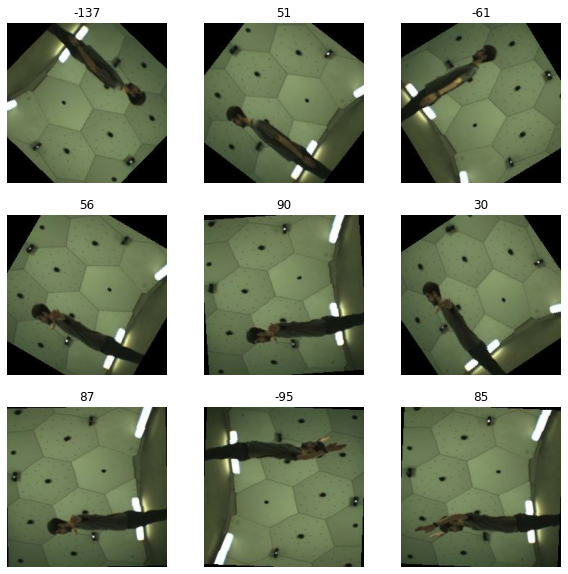

In [29]:
plt.figure(figsize=(10, 10))
for images, labels in ds_test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("float32"))
        plt.title(labels[i].numpy().astype("str"))
        plt.axis("off")
    

In [30]:
loss, mae, mse = model.evaluate(ds_test, verbose=2)

316/316 - 171s - loss: 2268.5482 - mean_absolute_error: 10.8273 - mean_squared_error: 2268.2129


In [31]:
test_predictions = model.predict(ds_test).flatten()

In [52]:
model.save_weights('./checkpoints/my_checkpoint')

In [88]:
model.save_weights('weights.h5')

In [89]:
model.save('saved_model/rotationnet')

In [91]:
new_model = tf.keras.models.load_model('saved_model/rotationnet')

KeyboardInterrupt: 

In [ ]:
loss, mae, mse = new_model.evaluate(ds_test, verbose=2)

In [95]:
test_directory = os.path.join(PATH, 'test_resized/images/')
result_csv = pd.read_csv(target_directory + 'test.csv')

In [94]:
result_csv["result"] = test_predictions

In [36]:
#result_csv.to_csv('test.csv')
result_csv

,Unnamed: 0,file_name,label,result
0,0,01_01_00000187.jpg,-137,-137.034060
1,1,01_01_00000193.jpg,51,47.824127
2,2,01_01_00000197.jpg,-61,-64.797480
3,3,01_01_00000205.jpg,56,60.213737
4,4,01_01_00000209.jpg,90,94.022285
5,5,01_01_00000214.jpg,30,33.085850
6,6,01_01_00000215.jpg,87,89.979620
7,7,01_01_00000222.jpg,-95,-87.793290
8,8,01_01_00000223.jpg,85,88.754840
9,9,01_01_00000227.jpg,170,167.609450


In [15]:
test_directory = os.path.join(PATH, 'test/images/')

In [22]:
test_directory = os.path.join(PATH, 'test/images/')
target_directory = os.path.join(PATH, 'rotationnet_results/images/')

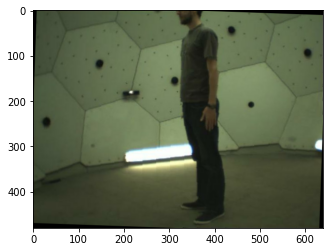

In [33]:
image = tf.io.read_file(test_directory + result_csv.file_name[100])
image = tf.image.decode_jpeg(image, channels=3)
image = tf.contrib.image.rotate(image, -result_csv.result[100] * 0.01745329251,interpolation='BILINEAR')
plt.imshow(image.numpy())

In [35]:
tf.keras.preprocessing.image.save_img(target_directory + result_csv.file_name[100], image, file_format = 'jpeg')

In [157]:
result_csv.file_name[0]

'01_01_00000187.jpg'

In [40]:
def rotate_image_for_openpose(result_csv, test_directory, target_directory):
    for i, j in zip(result_csv.file_name, result_csv.result):
        image = tf.io.read_file(test_directory + i)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.contrib.image.rotate(image, -j * 0.01745329251, interpolation='BILINEAR')
        tf.keras.preprocessing.image.save_img(target_directory + i, image, file_format = 'jpeg')
    

In [ ]:
rotate_image_for_openpose(result_csv, test_directory, target_directory)